# Crack Detection using Deep Learning

<h2>Objective</h2><ul>

This project aims to detect cracks in images using deep learning techniques. The dataset consists of positive and negative images, where positive images contain cracks and negative images do not. The task is to train a deep learning model to accurately classify images as cracked or not cracked.


Downloading and extracting the dataset

In [1]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

In [2]:
#!unzip -q Positive_tensors.zip 

In [3]:
#! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
#!unzip -q Negative_tensors.zip

In [4]:
#!pip install torchvision

In [5]:
#! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip

Importing the required libraries

In [6]:
# Import the required libraries
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import time
torch.manual_seed(0)

In [7]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import numpy as np
import zipfile
import os

In [8]:
# Set up the directories and file paths
directory = os.getcwd()
zipped_file = os.path.join(directory, "data/concrete_crack_images_for_classification.zip")
data_directory = os.path.join(directory, "data")

# Extract the zip file
with zipfile.ZipFile(zipped_file, "r") as zip_ref:
    zip_ref.extractall(data_directory)

<h2>Displaying and analyzing the Images</h2><ul>

Get the file paths for positive and negative images.

In [9]:
negative='Negative'
positive='Positive'
positive_file_path=os.path.join(data_directory,positive)
negative_file_path=os.path.join(data_directory,negative)

In [10]:
negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()


Display the first 3 positive images

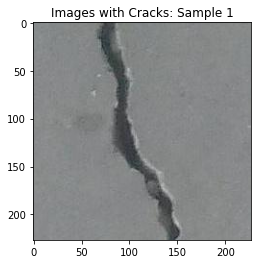

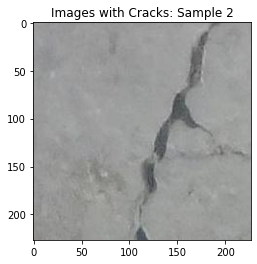

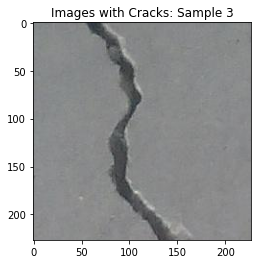

In [11]:
for i in range(3):
    image1 = Image.open(positive_files[i])
    plt.imshow(image1)
    plt.title(f"Images with Cracks: Sample {i+1}")
    plt.show()

Display the first 3 negative images

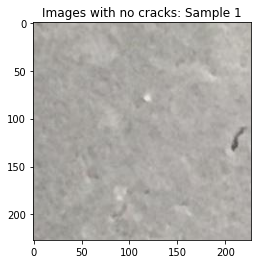

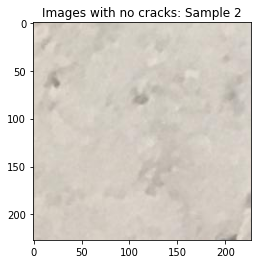

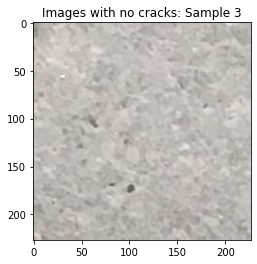

In [12]:
for i in range(3):
    image1 = Image.open(negative_files[i])
    plt.imshow(image1)
    plt.title(f"Images with no cracks: Sample {i+1}")
    plt.show()

### Data Preparation for Training

In [13]:
# Calculate the number of samples
number_of_samples = len(positive_files)+len(negative_files)

# Create the target labels (0 for no cracks, 1 for cracks)
Y=torch.zeros([number_of_samples])
Y=Y.type(torch.LongTensor)
Y[::2]=1
Y[1::2]=0

In [14]:
# Create a list of file paths for both positive and negative images
all_files = []
min_length = min(len(positive_files), len(negative_files))
for i in range(min_length):
    all_files.append(positive_files[i])
    all_files.append(negative_files[i])


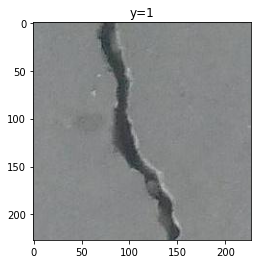

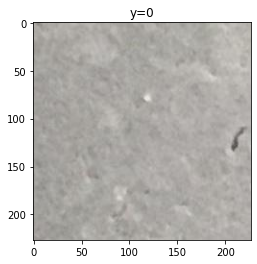

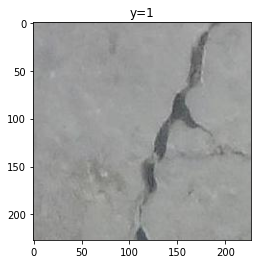

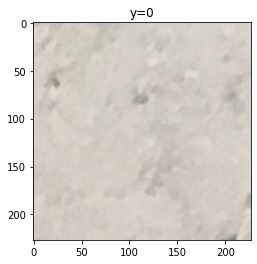

In [15]:
# Display the first 4 images with their corresponding labels
for y,file in zip(Y, all_files[0:4]):
    plt.imshow(Image.open(file))
    plt.title("y="+str(y.item()))
    plt.show()

In [16]:
# A function that displays the images
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [17]:
# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    # plt.subplot(2, 1, 2)
    # plt.plot(training_results['validation_accuracy'])
    # plt.ylabel('accuracy')
    # plt.xlabel('epochs')   
    # plt.show()

<h2 id="data_class">Dataset Class</h2>

In [18]:
# Create a custom Dataset class
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=os.getcwd()
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transfom to be utilized on the image
        self.transform = transform
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000] 
            self.Y=self.Y[0:30000] 
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Determine the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it to the image
        if self.transform:
            image = self.transform(image)

        return image, y

### Creating Dataset Objects

In [19]:
# Define the model architecture
model = models.resnet18(pretrained = True)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
train_dataset = Dataset(transform=transform, train=True)
validation_dataset = Dataset(transform=transform, train=False)

C:\Users\moyin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moyin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Print the shape of an image from the training dataset
train_dataset[0][0].shape

torch.Size([3, 227, 227])

In [21]:
# Set the requires_grad parameter for model parameters
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(512,2)


In [22]:
#Print the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Defining the loss function and optimizer


In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [25]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.001)


In [26]:
n_epochs = 1
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)
N_train=len(train_dataset)

# Define the training function
def train_model(model,n_epochs,criterion,optimizer,validation_loader,train_loader):
    metrics = {'training_loss': [],'validation_accuracy': []}
    for epoch in range(n_epochs):
        loss_sublist = []
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            metrics['training_loss'].append(loss.data.item())
            
        loss_list.append(np.mean(loss_sublist))
            
        correct = 0
        # perform a prediction on the validation data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = (correct / N_test)
        loss_list.append(loss.data)
        metrics['validation_accuracy'].append(accuracy)
    
    return metrics
    

In [27]:
# Train the model and get the training metrics
metrics = train_model(model,n_epochs,criterion,optimizer,validation_loader,train_loader)

C:\Users\moyin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\moyin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


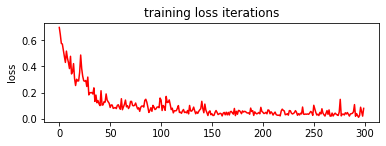

In [28]:
# Plot the training loss
plot_accuracy_loss(metrics)

In [29]:
# Display the metrics
metrics

{'training_loss': [0.6993213891983032,
  0.6449136137962341,
  0.5768054723739624,
  0.5721768736839294,
  0.5213533639907837,
  0.4759582281112671,
  0.4309495985507965,
  0.5178214907646179,
  0.4637329876422882,
  0.429421067237854,
  0.3836771845817566,
  0.4778916537761688,
  0.3425828516483307,
  0.3584594428539276,
  0.42174750566482544,
  0.30674442648887634,
  0.2536274492740631,
  0.3018016219139099,
  0.2885113060474396,
  0.28910258412361145,
  0.35446682572364807,
  0.48769909143447876,
  0.3837994635105133,
  0.3251008689403534,
  0.28984344005584717,
  0.2866310179233551,
  0.2923722565174103,
  0.24632850289344788,
  0.31853175163269043,
  0.18170534074306488,
  0.1992637813091278,
  0.1978597193956375,
  0.19977030158042908,
  0.18851691484451294,
  0.23570266366004944,
  0.1316504329442978,
  0.18027181923389435,
  0.12116013467311859,
  0.13821516931056976,
  0.11347853392362595,
  0.09954479336738586,
  0.21363896131515503,
  0.10334430634975433,
  0.105046659708023

In [30]:
# Define a function to show a data sample
def show_data(data_sample):
    image = data_sample[0].numpy().squeeze()  # Remove unnecessary dimensions
    plt.imshow(image, cmap='gray')
    # plt.title('y = ' + str(data_sample[1]))
    # plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    # plt.title('y = ' + str(data_sample[1]))
    # plt.show()

# Determining the first four misclassified samples

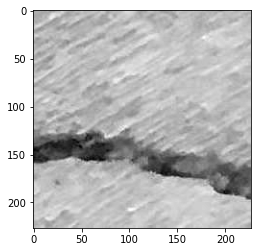

sample95 predicted value: tensor([0]) actual value: 1


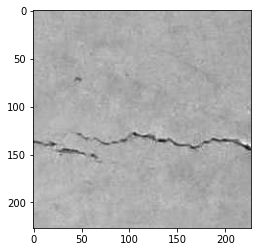

sample143 predicted value: tensor([0]) actual value: 1


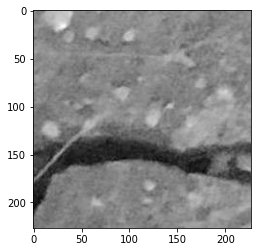

sample191 predicted value: tensor([0]) actual value: 1


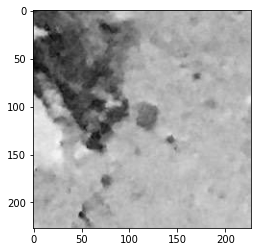

sample452 predicted value: tensor([1]) actual value: 0


In [31]:


count = 0
i = 0

model.eval()
for x, y in validation_dataset:
    count += 1
    z = model(x.unsqueeze(0))
    _,yhat = torch.max(z, 1)
    if yhat != y:
        show_data(x)
        plt.show()
        print(f"sample{count} predicted value: {yhat} actual value: {y}")
        i+=1
    if i >= 4:
        break

# Conclusion

In the "Crack detection using deep learning" project, a ResNet-18 model was utilized to classify images as cracked or not cracked accurately. The model achieved an accuracy of 98% in identifying cracks in the pictures after training the model for only one epoch. The project showcased the effectiveness of deep learning techniques, specifically the ResNet-18 architecture, in crack detection tasks. The model was trained and evaluated using a dataset of positive and negative images. The project utilized various data processing techniques and libraries such as torch, torchvision, and PIL. The project demonstrates the potential of deep learning for crack detection and serves as a foundation for further improvements in this field.